In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import os, sys, glob
from tqdm import tqdm
from model import model1
sys.path.insert(0,"/home/msmith/misc/py/")
from performance import Performance
from hStackBatch import hStackBatch
from loadData import loadData
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams["figure.figsize"] = 20, 10

def displayBatch(XY):
    try:
        X,Y = XY
        X *= 255.0
        names = train.decodeToName(Y)
        bs = X.shape[0]
        X = X.astype(np.uint8)
        fig = plt.figure(figsize=(40,20))
        idx = 0
        for i in range(1,bs+1):
            ax = fig.add_subplot(1,bs+1,i)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            plt.imshow(X[idx])
            ax.set_title(names[idx])
            idx +=1
        plt.show()
    except IndexError:
        print("OOB")

def show(X,Y="none"):
    bs, h, w, c = X.shape
    X = X.reshape(bs*h,w,c)[:,:,::-1]
    plt.imshow(X)
    plt.title(Y)
    plt.show()




In [2]:
if __name__ == "__main__":
    batchSize  = 10
    batchCapacity = 40
    nThreads = 32

    ## HyperParameter defaults
    h, w, c = 150, 200, 3
    nClasses = 447
    inDims = [None,h,w,c]
    nFeatsInit = 64
    nFeatsInc = 32
    learningRate = tf.placeholder(tf.float32)
    load = 0
    display = 1
    disFreq = 400
    lr = 3e-4

    # Decode csv
    csvPathTr = "/home/msmith/kaggle/whale/trainCV.csv"
    csvPathTe = "/home/msmith/kaggle/whale/testCV.csv"
    xTr, yTr, yPathsTr = loadData(csvPathTr,shape=[h,w,c],batchSize=batchSize,batchCapacity=batchCapacity,nThreads=nThreads)
    
    # Define placeholders and model
    yPredTr = model1(xTr,inDims=inDims,nClasses=nClasses,nFeatsInit=nFeatsInit,nFeatsInc=nFeatsInc) # model
    ce = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(yPredTr,yTr))
    trainStep = tf.train.AdamOptimizer(learningRate).minimize(ce)
    correct = tf.equal(tf.argmax(yPredTr,1), tf.argmax(yTr,1))
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
    #yPredTe = model1(xTe,inDims=inDims,nClasses=nClasses,nFeatsInit=nFeatsInit,nFeatsInc=nFeatsInc) # model
    
    

Tensor("Mul:0", shape=(?, ?, ?), dtype=float32)
(10, 150, 200, 3)
(10, 75, 100, 64)
(10, 38, 50, 96)
(10, 19, 25, 128)
(10, 10, 13, 160)
(10, 5, 7, 192)
(10, 3, 4, 224)
(10, 2, 2, 256)
(10, 1024)
(10, 447)


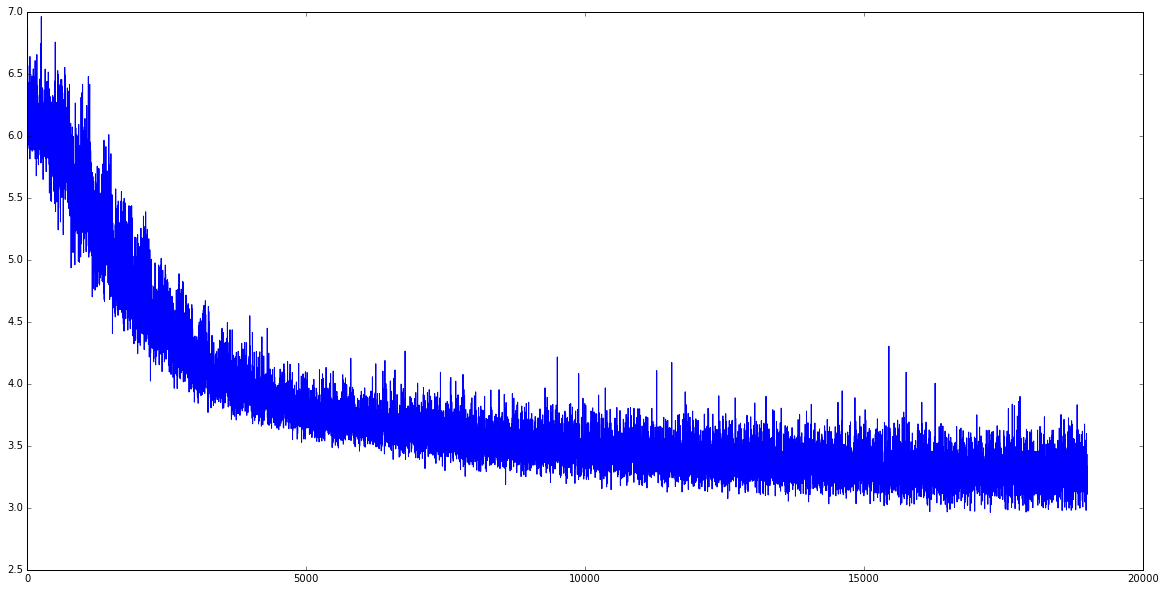

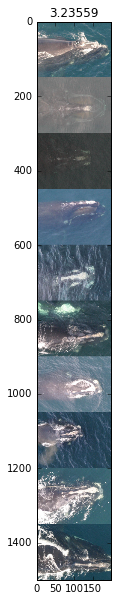

 95%|█████████▌| 19002/20000 [36:22<03:31,  4.72it/s]

learning rate now = 0.0003


100%|██████████| 20000/20000 [38:16<00:00,  8.81it/s]


In [3]:
if __name__ == "__main__":

    init = tf.initialize_all_variables()
            
    with tf.Session() as sess:
        sess.run(init)
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(sess=sess,coord=coord)
                
        count = 0
        nIterations = 20000
        losses = np.empty(nIterations)
        for i in tqdm(xrange(nIterations)):
            _, loss_, x_, y_,yPred_, yPathsTr_ = sess.run([trainStep, ce, xTr, yTr, yPredTr, yPathsTr],feed_dict={learningRate:lr})
            losses[i] = loss_
            if i % 1000 == 0 and i > 0:
                clear_output()
                plt.plot(losses[:i])
                plt.show()
                show(x_,loss_)
                count += x_.shape[0]
            if i % 1000 == 0 and i>0:
                #lr /= 1.3
                print("learning rate now = {0}".format(lr))